# Question 1: Predict how many variants will have conflicting / non-conflicting classifications, why are they considered to have conflicting classifications? Compare the prediction result with the true label to get an accuracy.
## Methodology:
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. Adaboost

In [2]:
# Import lib
# ===========================================================
import csv
import pandas as pd
import numpy as np
import random
import time
import collections
import math
import sys
from tqdm import tqdm
from time import sleep

import matplotlib.pyplot as plt
# %matplotlib inline
plt.style.use('fivethirtyeight')

from datascience import *
from scipy import stats

import statsmodels.formula.api as smf
import statsmodels.api as sm
# from statsmodels.genmod.families.links import logit
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

## Method 1: Logistic Regression

### 1. Initialization

In [30]:
# Initialize useful data
# ===========================================================
df = pd.read_csv('clinvar_conflicting_clean.csv', low_memory=False)
df = df.fillna(value=0)

# resample to get a balanced dataset
df_zero = df.loc[df['CLASS'] == 0]
df_zero = df_zero.sample(n=1000)
df_one = df.loc[df['CLASS'] == 1]
df_one = df_one.sample(n=1000)

# concatenate and reallocate all data
df = pd.concat([df_zero, df_one])
df = df.sample(n = df.shape[0])
all_rows = df.values.tolist()
row_num = len(all_rows)
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDN,CLNHGVS,...,Codons,STRAND,BAM_EDIT,SIFT,PolyPhen,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62,CLASS
43602,14,64560091,TG,CA,0.0000,0.00000,0.0000,"MedGen:C0410189,Orphanet:ORPHA261,SNOMED_CT:11...",Emery-Dreifuss_muscular_dystrophy|Emery-Dreifu...,NC_000014.8:g.64560091_64560092invTG,...,TGg/CAg,1.0,0,0,0,0.852000,22.300,3.033567,-2.0,1
42435,13,52515275,A,G,0.0000,0.00000,0.0000,"MedGen:C0019202,OMIM:277900,Orphanet:ORPHA905,...",Wilson_disease|not_specified,NC_000013.10:g.52515275A>G,...,agT/agC,-1.0,0,0,0,0.034000,9.078,0.738640,0.0,1
8301,2,166893002,A,C,0.0000,0.00000,0.0000,"MedGen:C0751122,OMIM:607208,Orphanet:ORPHA3306...",Severe_myoclonic_epilepsy_in_infancy|not_speci...,NC_000002.11:g.166893002A>C,...,ttT/ttG,-1.0,0,deleterious,possibly_damaging,0.000138,25.700,5.296657,0.0,1
13170,3,8787481,C,T,0.0000,0.00000,0.0000,"MeSH:D008133,MedGen:C0023976,SNOMED_CT:9651007...",Long_QT_syndrome|not_specified,NC_000003.11:g.8787481C>T,...,ttC/ttT,1.0,OK,0,0,0.046600,15.840,1.940118,0.0,1
59041,19,36342212,C,T,0.2332,0.31479,0.2919,"MedGen:C0403399,OMIM:256300,Orphanet:ORPHA839,...",Finnish_congenital_nephrotic_syndrome|not_spec...,NC_000019.9:g.36342212C>T,...,Gag/Aag,-1.0,0,deleterious,probably_damaging,0.574000,26.600,5.624579,1.0,0


### 2. Preprocessing

In [31]:
# Divide whole dataset into Input and Output
# ===========================================================
# Features - all columns except 'CLASS'
# Target label - 'CLASS' column
X = df.drop('CLASS', axis=1)
y = df['CLASS']

# One hot encoding
X = pd.get_dummies(X, drop_first=True)
y = pd.get_dummies(y, drop_first=True)

# Train/Test split
train_X, test_X, train_y, test_y = train_test_split(X, y)

# Normalize using StandardScaler
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

### 3. Train and Test

In [32]:
# Train Model
# ===========================================================
model = LogisticRegression()

start = time.time()

model.fit(train_X, train_y)
pred_y = model.predict(test_X)
score = accuracy_score(test_y, pred_y)

end = time.time()
print("Logistic Regression Model Trained! Time: %.03fs" % (end - start))

/Users/frostace/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/frostace/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression Model Trained! Time: 1.577s


### 4. Performance: Acc, ROC and AUC

In [33]:
# Compare Actual label and Predicted label
# ===========================================================
pred_score = model.predict_proba(test_X)
fpr, tpr, thresholds = roc_curve(test_y, pred_score[:,1])
final = Table().with_column('IDX', [i for i in range(len(pred_score))])
final = final.with_columns('ACT_CLASS', test_y.transpose().values.tolist()[0], 'PRE_CLASS', pred_score[:, 1])

In [34]:
# Compute TN, TP, FN, FP, etc.
# ===========================================================
ROC = Table(make_array('CUTOFF', 'TN', 'FN', 'FP', 'TP', 'ACC'))
step_size = 0.05
for cutoff in np.arange(0, 1 + step_size, step_size):
    temp_final = final.with_column('INDICATE', final.apply(lambda x, y: (int(x >= cutoff) << 1) + y, 'PRE_CLASS', 'ACT_CLASS'))
    # 00(0) -> TN
    # 01(1) -> FN
    # 10(2) -> FP
    # 11(3) -> TP
    group = temp_final.group('INDICATE')
    indicator = group.column(0)
    counts = group.column(1)
#     print(indicator, counts)
    output = [cutoff]
    idx = 0
    for i in range(4):
#         print(counts[idx])
        if i in indicator:
            output.append(counts[idx])
            idx += 1
        else:
            output.append(0)
    acc = (output[1] + output[4]) / sum(output[1:])
    output.append(acc)
    ROC = ROC.with_row(output)
ROC = ROC.with_columns('SENSITIVITY', ROC.apply(lambda TP, FN: TP / (TP + FN + 0.00000001), 'TP', 'FN'))
ROC = ROC.with_columns('FPR', ROC.apply(lambda TN, FP: FP / (TN + FP + 0.00000001), 'TN', 'FP'))
ROC = ROC.with_column('FMEAS', ROC.apply(lambda TP, FP, FN: 2 * (TP / (TP + FN)) * (TP / (TP + FP)) / (TP / (TP + FN) + TP / (TP + FP)), 'TP', 'FP', 'FN'))

/Users/frostace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


In [35]:
ROC.show()

CUTOFF,TN,FN,FP,TP,ACC,SENSITIVITY,FPR,FMEAS
0,0,0,256,244,0.488,1,1,0.655914
0.05,53,14,203,230,0.566,0.942623,0.792969,0.679468
0.1,77,30,179,214,0.582,0.877049,0.699219,0.6719
0.15,93,44,163,200,0.586,0.819672,0.636719,0.658979
0.2,106,55,150,189,0.59,0.77459,0.585937,0.64837
0.25,114,66,142,178,0.584,0.729508,0.554687,0.631206
0.3,120,68,136,176,0.592,0.721311,0.53125,0.633094
0.35,128,79,128,165,0.586,0.67623,0.5,0.614525
0.4,134,85,122,159,0.586,0.651639,0.476562,0.605714
0.45,144,93,112,151,0.59,0.618852,0.4375,0.595661


The acc and ROC would be slightly different each time due to the random sampling at the beginning.

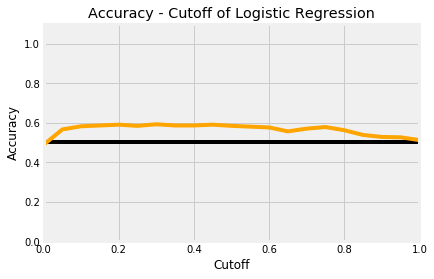

In [36]:
# Acc Curve by cutoff
# ===========================================================
fig = plt.figure()
plt.xlabel('Cutoff')
plt.ylabel('Accuracy')
plt.title('Accuracy - Cutoff of Logistic Regression')
plt.plot(np.arange(0, 1.1, 0.1), [0.5 for i in np.arange(0, 1.1, 0.1)], color='black')
plt.plot(ROC.column('CUTOFF'), ROC.column('ACC'), color='orange')
plt.axis([0, 1, 0, 1.1])
plt.show()
fig.savefig('Logistic ACC.png', bbox_inches='tight')

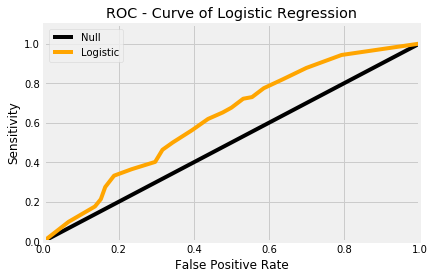

In [37]:
# ROC_CURVE
# ===========================================================
fig = plt.figure()
plt.xlabel('False Positive Rate')
plt.ylabel('Sensitivity')
plt.title('ROC - Curve of Logistic Regression')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), color='black')
plt.plot(ROC.column('FPR'), ROC.column('SENSITIVITY'), color='orange')
plt.legend(['Null', 'Logistic'])
plt.axis([0, 1, 0, 1.1])
plt.show()
fig.savefig('Logistic ROC.png', bbox_inches='tight')

In [38]:
# Compute AUC
# ===========================================================
length = len(ROC.column('FPR'))
auc = 0
for i in range(length - 1):
    auc += 0.5 * abs(ROC.column('FPR')[i + 1] - ROC.column('FPR')[i]) * (ROC.column('SENSITIVITY')[i] + ROC.column('SENSITIVITY')[i + 1])
print("auc = %.03f" %auc)

auc = 0.623


## Method 2: Decision Tree

### 1. Initialization

In [39]:
# Initialize useful data
# ===========================================================
df = pd.read_csv('clinvar_conflicting_clean.csv', low_memory=False)
df[['CLNVI', 'MC', 'SYMBOL', 'Feature_type', 'Feature', 'BIOTYPE', 
 'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids', 'Codons', 
 'BAM_EDIT', 'SIFT', 'PolyPhen']] = df[['CLNVI', 'MC', 'SYMBOL', 'Feature_type', 'Feature', 'BIOTYPE', 
 'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids', 'Codons', 
 'BAM_EDIT', 'SIFT', 'PolyPhen']].fillna(value=0)
df = df.sample(n = df.shape[0])
columns_backup = df.columns
all_rows = df.values.tolist()
row_num = len(all_rows)

### 2. Balancing

In [40]:
# Balancing Dataset
# ===========================================================
df_zero = df.loc[df['CLASS'] == 0]
df_zero = df_zero.sample(n=10000)
df_one = df.loc[df['CLASS'] == 1]
df_one = df_one.sample(n=10000)

df = pd.concat([df_zero, df_one])
df = df.sample(n = df.shape[0])
all_rows = df.values.tolist()
row_num = len(all_rows)
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDN,CLNHGVS,...,Codons,STRAND,BAM_EDIT,SIFT,PolyPhen,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62,CLASS
62494,22,29099474,T,A,0.0000,0.00000,0.0000,"MedGen:C0027672,SNOMED_CT:699346009|MedGen:CN1...",Hereditary_cancer-predisposing_syndrome|not_sp...,NC_000022.10:g.29099474T>A,...,0,-1.0,OK,0,0,0.3560,1.087,-0.202022,NaN,0
31336,10,88446937,G,A,0.0001,0.00044,0.0012,"Human_Phenotype_Ontology:HP:0011664,MedGen:C40...",Left_ventricular_noncompaction_cardiomyopathy|...,NC_000010.10:g.88446937G>A,...,gcG/gcA,1.0,0,0,0,0.0734,9.987,0.886503,NaN,1
4942,2,39213367,G,C,0.0002,0.00016,0.0000,"MedGen:CN166718,Orphanet:ORPHA98733|MedGen:CN1...",Rasopathy|not_specified,NC_000002.11:g.39213367G>C,...,gaC/gaG,-1.0,OK,tolerated_low_confidence,benign,0.0249,0.060,-0.734751,2.0,1
27588,9,21971092,C,T,0.0000,0.00000,0.0000,"MedGen:C0027672,SNOMED_CT:699346009|MedGen:C15...",Hereditary_cancer-predisposing_syndrome|Heredi...,NC_000009.11:g.21971092C>T,...,gGc/gAc,-1.0,OK,deleterious,probably_damaging,0.1440,33.000,7.093824,-1.0,1
939,1,40555082,C,T,0.0001,0.00005,0.0000,"MedGen:C1850451,OMIM:256730,Orphanet:ORPHA2283...",Ceroid_lipofuscinosis_neuronal_1|not_specified,NC_000001.10:g.40555082C>T,...,cGc/cAc,-1.0,0,0,0,0.2040,21.800,2.892771,NaN,0


### 3. Decision Tree Structure Implementation

In [41]:
# Decision Tree Structure
# ===========================================================
def is_numeric(value):
    return isinstance(value, int) or isinstance(value, float)

# === LeafNode is the prediction result of this branch ===
class LeafNode:
    def __init__(self, rows):
        labels = [row[-1] for row in rows]
        self.prediction = collections.Counter(labels)

# === DecisionNode is an attribute / question used to partition the data ===
class DecisionNode:
    def __init__(self, question = None, left_branch = None, right_branch = None):
        self.question = question
        self.left_branch = left_branch
        self.right_branch = right_branch
    
class DecisionTree:
    def __init__(self, training_attribute, training_data, method = "CART"):
        self.attribute = training_attribute     # takein attribute and data separately
        self.train = training_data[1:]
        self.row_num = len(self.train)
        self.column_num = len(self.attribute)
        self.method = method.upper()            # convert to upper case for general use
        self.labels = self.uniq_val(-1)
        if self.method not in ["C4.5", "CART", "HYBRID"]:
            print("Error: Please choose a valid method!")
            return None
        self.root = self.build_tree(self.train)
    
    def uniq_val(self, column):
        return set([self.train[i][column] for i in range(len(self.train))])
    
    # when raising a question.
    # if it's a categorical attribute, we simply iterate all categories
    # if it's a numeric attribute, we iterate the set of possible numeric values 
    class Question:
        def __init__(self, column, ref_value, attribute):
            self.column = column
            self.ref_value = ref_value if ref_value else "None"
            self.attri = attribute

        def match(self, row):
            if is_numeric(self.ref_value):
                try:
                    return row[self.column] >= self.ref_value
                except:
                    print("Error occured in ", row)
                    return True
            else:
                return row[self.column] == self.ref_value

        def __repr__(self):
            operand = ">=" if is_numeric(self.ref_value) else "=="
            return "Is %s %s %s?" % (self.attri[self.column], operand, str(self.ref_value))
    
    # === Method 1 - C4.5 ===
    def entropy(self, rows):
        # === Bits used to store the information ===
        labels = [row[-1] for row in rows]
        frequency = collections.Counter(labels).values()
        pop = sum(frequency)
        H = 0
        for f in frequency:
            p = f / pop
            H -= p * math.log(p, 2)
        return H
    
    # === Method 2 - CART ===
    def gini(self, rows):
        # === Probability of misclassifying any of your label, which is impurity ===
        labels = [row[-1] for row in rows]
        frequency = collections.Counter(labels).values()
        pop = sum(frequency)
        gini = 1
        for f in frequency:
            p = f / pop
            gini -= p ** 2
        return gini
    
    # === Calculate Gain Info ===
    # I'm actually returning the gain info reduction
    def info(self, branches, root):
        # === Objective: to find the best question which can maximize info ===
        root_size = float(len(root))
        if self.method == "C4.5":  # Here I pick the GainRatio Approach
            root_uncertainty = self.entropy(root)
            gain_info = root_uncertainty
            split_info = 0
            for branch in branches:
                if not branch: continue
                gain_info -= len(branch) / root_size * self.entropy(branch)
                split_info -= float(len(branch)) / root_size * math.log(float(len(branch)) / root_size)
#                 print(gain_info, split_info)
            return gain_info / split_info
        elif self.method == "CART":
            root_uncertainty = self.gini(root)
            gain_info = root_uncertainty
            for branch in branches:
                if not branch: continue
                gain_info -= len(branch) / root_size * self.gini(branch)
            return gain_info
        elif self.method == "HYBRID":
            pass
        pass
    
    # === Here I only do Binary Partitions ===
    def partition(self, rows, question):
        true_rows = []
        false_rows = []
        for row in rows:
            if question.match(row):
                true_rows.append(row)
            else:
                false_rows.append(row)
        return true_rows, false_rows
    
    def find_best_question(self, rows):
        max_info_attenuation = 0
        best_question = self.Question(0, self.train[0][0], self.attribute)
        # === Iterate through all question candidates ===
        # === TODO: Maybe Iteration here can be optimized ===
        for col in range(self.column_num - 1): # minus 1 to avoid using the label as attribute
            ref_candidates = self.uniq_val(col)
            for ref_value in ref_candidates:
                if ref_value == "null": continue # avoid using null values to generate a question
                q = self.Question(col, ref_value, self.attribute)
                temp_true_rows, temp_false_rows = self.partition(rows, q)
                temp_info_attenuation = self.info([temp_true_rows, temp_false_rows], rows)
                if temp_info_attenuation >= max_info_attenuation:
                    max_info_attenuation = temp_info_attenuation
                    best_question = q
        return max_info_attenuation, best_question
        
    # === Input rows of data with attributes and labels ===
    def build_tree(self, rows):
        # === Assign all rows as root of the whole decision tree ===
        # === We have met the leaf node if gini(rows) is 0 or no question candidates left ===
        gain_reduction, q = self.find_best_question(rows)
#         if gain_reduction <= 0.003:
        if self.gini(rows) <= 0.48:
            return LeafNode(rows)
        true_rows, false_rows = self.partition(rows, q)
        # === Recursion after we have found a optimal question ===
        return DecisionNode(q, self.build_tree(true_rows), self.build_tree(false_rows))
    
    # === Input a row of data with attributes (and no label), predict its label with our decision tree ===
    # === Actually it can contain a label, we just don't use it ===
    # === walk down the decision tree until we reach the leaf node ===
    def classify(self, row, node):
        if isinstance(node, LeafNode):
#             print("===", node.prediction)
            return node.prediction
        
        if node.question.match(row):
#             print(node.question, True)
            return self.classify(row, node.left_branch)
        else:
#             print(node.question, False)
            return self.classify(row, node.right_branch)
    
    def print_tree(self, node, spacing=""):
        # Base case: we've reached a leaf
        if isinstance(node, LeafNode):
            print (spacing + "Predict", node.prediction)
            return

        # Print the question at this node
        print (spacing + str(node.question))

        # Call this function recursively on the true branch
        print (spacing + '--> True:')
        self.print_tree(node.left_branch, spacing + "  ")

        # Call this function recursively on the false branch
        print (spacing + '--> False:')
        self.print_tree(node.right_branch, spacing + "  ")


### 4. Split Train Test

In [42]:
# Divide whole dataset into training set and testing set
# ===========================================================
training_percentage = 0.01  # percent of partition of training dataset
training_size = int(row_num * training_percentage)
testing_size = row_num - training_size
training_attribute = list(df.columns)      # i omitted the 'CLASS' inside the decision tree structure
training_data = all_rows[: training_size]  # training data should include header row
testing_data = all_rows[training_size: ]   # testing data don't need to include header row

### 5. Training Decision Tree

In [43]:
# Training
# ===========================================================
start = time.time()
tree = DecisionTree(training_attribute, training_data, "CART")
end = time.time()
print("Decision Tree Trained! Time: %.03fs" % (end - start))

Decision Tree Trained! Time: 1.321s


In [44]:
# print the tree to visualize
# tree.print_tree(tree.root)

### 6. Testing Decision Tree

In [45]:
# Testing and Computing TN, TP, FN, FP, etc. 
# ===========================================================
ROC = Table(make_array('CUTOFF', 'TN', 'FN', 'FP', 'TP', 'ACC'))
step_size = 0.05
CMap = {0: 'TN', 1: 'FN', 2: 'FP', 3: 'TP'}
# 00(0) -> TN
# 01(1) -> FN
# 10(2) -> FP
# 11(3) -> TP
for cutoff in np.arange(0, 1 + step_size, step_size):
    # interactive progress printing
    sys.stdout.write('\r')
    sys.stdout.write("Testing: [%-20s] %d%%" % ('='*int(cutoff * 100 / 5), int(cutoff * 100)))
    sys.stdout.flush()
    Confusion = {'TN': 0, 'FN': 0, 'FP': 0, 'TP': 0}
    for row in testing_data:
        # prediction is a counter of label 1 and 0
        pred_counter = tree.classify(row, tree.root)
        true_rate = pred_counter.get(1, 0) / (pred_counter.get(1, 0) + pred_counter.get(0, 0) + 0.00000001)
#         print(true_rate)
        true_pred = 1 if true_rate >= cutoff else 0
        indicator = (true_pred << 1) + row[-1]
        # accordingly update confusion matrix
        Confusion[CMap[indicator]] += 1
    # concatenate the confusion matrix values into the overall ROC Table
    thisline = [cutoff] + list(Confusion.values()) + [(Confusion['TP'] + Confusion['TN']) / sum(Confusion.values())]
    ROC = ROC.with_row(thisline)
ROC = ROC.with_column('SENSITIVITY', ROC.apply(lambda TP, FN: TP / (TP + FN + 0.00000001), 'TP', 'FN'))
ROC = ROC.with_column('FPR', ROC.apply(lambda TN, FP: FP / (TN + FP + 0.00000001), 'TN', 'FP'))
ROC = ROC.with_column('FMEAS', ROC.apply(lambda TP, FP, FN: 2 * (TP / (TP + FN)) * (TP / (TP + FP)) / (TP / (TP + FN) + TP / (TP + FP)), 'TP', 'FP', 'FN'))

Testing: [====================] 100%

/Users/frostace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars


In [46]:
ROC.show()

CUTOFF,TN,FN,FP,TP,ACC,SENSITIVITY,FPR,FMEAS
0,0,0,9906,9894,0.499697,1,1,0.666397
0.05,928,97,8978,9797,0.541667,0.990196,0.906319,0.683456
0.1,928,97,8978,9797,0.541667,0.990196,0.906319,0.683456
0.15,928,97,8978,9797,0.541667,0.990196,0.906319,0.683456
0.2,928,97,8978,9797,0.541667,0.990196,0.906319,0.683456
0.25,928,97,8978,9797,0.541667,0.990196,0.906319,0.683456
0.3,928,97,8978,9797,0.541667,0.990196,0.906319,0.683456
0.35,3811,1791,6095,8103,0.601717,0.818981,0.615284,0.672671
0.4,3811,1791,6095,8103,0.601717,0.818981,0.615284,0.672671
0.45,3811,1791,6095,8103,0.601717,0.818981,0.615284,0.672671


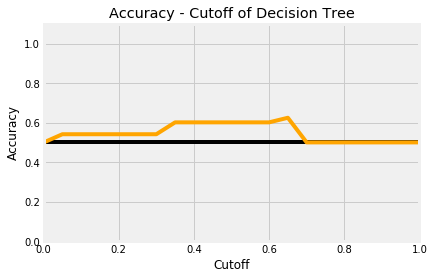

In [47]:
# Acc Curve by cutoff
# ===========================================================
fig = plt.figure()
plt.xlabel('Cutoff')
plt.ylabel('Accuracy')
plt.title('Accuracy - Cutoff of Decision Tree')
plt.plot(np.arange(0, 1.1, 0.1), [0.5 for i in np.arange(0, 1.1, 0.1)], color='black')
plt.plot(ROC.column('CUTOFF'), ROC.column('ACC'), color='orange')

plt.axis([0, 1, 0, 1.1])
plt.show()
fig.savefig('Decision Tree ACC.png', bbox_inches='tight')

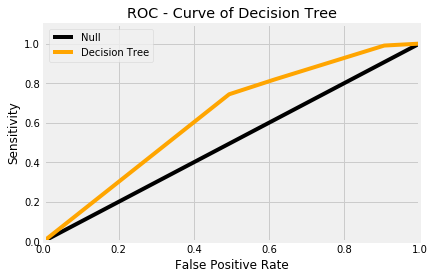

In [48]:
# ROC_CURVE
# ===========================================================
fig = plt.figure()
plt.xlabel('False Positive Rate')
plt.ylabel('Sensitivity')
plt.title('ROC - Curve of Decision Tree')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), color='black')
plt.plot(ROC.column('FPR'), ROC.column('SENSITIVITY'), color='orange')

plt.legend(['Null', 'Decision Tree'])
plt.axis([0, 1, 0, 1.1])
plt.show()
fig.savefig('Decision Tree ROC.png', bbox_inches='tight')

In [49]:
# Compute AUC
# ===========================================================
length = len(ROC.column('FPR'))
auc = 0
for i in range(length - 1):
    auc += 0.5 * abs(ROC.column('FPR')[i + 1] - ROC.column('FPR')[i]) * (ROC.column('SENSITIVITY')[i] + ROC.column('SENSITIVITY')[i + 1])
print("auc = %.03f" %auc)

auc = 0.635


## Method 3: Random Forest

### 1. Initialization

In [3]:
# Initialize useful data
# ===========================================================
df = pd.read_csv('clinvar_conflicting_clean.csv', low_memory=False)
columns_to_change = ['ORIGIN', 'EXON', 'INTRON', 'STRAND', 'LoFtool', 'CADD_PHRED', 'CADD_RAW', 'BLOSUM62']
df[['CLNVI', 'MC', 'SYMBOL', 'Feature_type', 'Feature', 'BIOTYPE', 
 'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids', 'Codons', 
 'BAM_EDIT', 'SIFT', 'PolyPhen']] = df[['CLNVI', 'MC', 'SYMBOL', 'Feature_type', 'Feature', 'BIOTYPE', 
 'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids', 'Codons', 
 'BAM_EDIT', 'SIFT', 'PolyPhen']].fillna(value=0)
df_zero = df.loc[df['CLASS'] == 0]
df_zero = df_zero.sample(n=10000)
df_one = df.loc[df['CLASS'] == 1]
df_one = df_one.sample(n=10000)

df = pd.concat([df_zero, df_one])
df = df.sample(n = df.shape[0])
all_rows = df.values.tolist()
row_num = len(all_rows)
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDN,CLNHGVS,...,Codons,STRAND,BAM_EDIT,SIFT,PolyPhen,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62,CLASS
1168,1,45796246,G,C,0.0000,0.00000,0.000,"MedGen:C0027672,SNOMED_CT:699346009|MedGen:CN1...",Hereditary_cancer-predisposing_syndrome|not_sp...,NC_000001.10:g.45796246G>C,...,0,-1.0,OK,0,0,0.0243,2.788,0.020761,NaN,0
31212,10,75874667,A,T,0.0026,0.00371,0.001,"MedGen:C1969639,OMIM:611407|MedGen:CN169374|Me...",Dilated_cardiomyopathy_1W|not_specified|Dilate...,NC_000010.10:g.75874667A>T,...,0,1.0,0,0,0,0.6020,3.950,0.131887,NaN,1
59774,19,49685947,G,A,0.0000,0.00000,0.000,"Gene:8184,MedGen:C1970298,OMIM:604559|Human_Ph...",Progressive_familial_heart_block_type_1B|Seizu...,NC_000019.9:g.49685947G>A,...,cGc/cAc,1.0,OK,deleterious,probably_damaging,0.7520,26.900,5.724808,NaN,1
34447,11,68707089,A,G,0.0001,0.00045,0.000,"Human_Phenotype_Ontology:HP:0007269,MedGen:C00...",Spinal_muscular_atrophy|Spinal_muscular_atroph...,NC_000011.9:g.68707089A>G,...,Aac/Gac,1.0,OK,tolerated,benign,0.0776,0.392,-0.397603,1.0,0
28142,9,97912342,C,A,0.0000,0.00000,0.000,"MedGen:C0015625,Orphanet:ORPHA84,SNOMED_CT:305...",Fanconi_anemia|Hereditary_cancer-predisposing_...,NC_000009.11:g.97912342C>A,...,ctG/ctT,-1.0,OK,0,0,0.9510,11.900,1.228404,NaN,1


### 2. Decision Tree Structure for Random Forest Implementation

In [4]:
# Decision Tree Structure for Random Forest
# ===========================================================
def is_numeric(value):
    return isinstance(value, int) or isinstance(value, float)

# === LeafNode is the prediction result of this branch ===
class LeafNode:
    def __init__(self, rows):
        labels = [row[-1] for row in rows]
        self.prediction = collections.Counter(labels)

# === DecisionNode is an attribute / question used to partition the data ===
class DecisionNode:
    def __init__(self, question = None, left_branch = None, right_branch = None):
        self.question = question
        self.left_branch = left_branch
        self.right_branch = right_branch
    
class DecisionTree:
    def __init__(self, all_attribs, training_attribs, training_data, method = "CART"):
        self.attribute = training_attribs     # takein attribute and data separately
        self.train = training_data
        self.row_num = len(self.train)
        self.attribute_colNums = [all_attribs.index(att) for att in training_attribs]
        self.method = method.upper()            # convert to upper case for general use
        self.labels = self.uniq_val(-1)
        if self.method not in ["C4.5", "CART", "HYBRID"]:
            print("Error: Please choose a valid method!")
            return None
        self.root = self.build_tree(self.train)
    
    def uniq_val(self, column):
        return set([self.train[i][column] for i in range(len(self.train))])
    
    # === when raising a question ===
    # if it's a categorical attribute, we simply iterate all categories
    # if it's a numeric attribute, we iterate the set of possible numeric values 
    class Question:
        def __init__(self, column, ref_value):
            self.column = column
            self.ref_value = ref_value if ref_value else "None"
#             self.attri = attribute

        def match(self, row):
            if is_numeric(self.ref_value):
                try:
                    return row[self.column] >= self.ref_value
                except:
                    print("Error occured in ", row)
                    return True
            else:
                return row[self.column] == self.ref_value

        def __repr__(self):
            operand = ">=" if is_numeric(self.ref_value) else "=="
            return "Is %s %s %s?" % (self.attri[self.column], operand, str(self.ref_value))
    
    # === Method 1 - C4.5 ===
    def entropy(self, rows):
        # === Bits used to store the information ===
        labels = [row[-1] for row in rows]
        frequency = collections.Counter(labels).values()
        pop = sum(frequency)
        H = 0
        for f in frequency:
            p = f / pop
            H -= p * math.log(p, 2)
        return H
    
    # === Method 2 - CART ===
    def gini(self, rows):
        # === Probability of misclassifying any of your label, which is impurity ===
        labels = [row[-1] for row in rows]
        frequency = collections.Counter(labels).values()
        pop = sum(frequency)
        gini = 1
        for f in frequency:
            p = f / pop
            gini -= p ** 2
        return gini
    
    # === Calculate Gain Info ===
    # I'm actually returning the gain info reduction
    def info(self, branches, root):
        # === Objective: to find the best question which can maximize info ===
        root_size = float(len(root))
        if self.method == "C4.5":  # Here I pick the GainRatio Approach
            root_uncertainty = self.entropy(root)
            gain_info = root_uncertainty
            split_info = 0
            for branch in branches:
                if not branch: continue
                gain_info -= len(branch) / root_size * self.entropy(branch)
                split_info -= float(len(branch)) / root_size * math.log(float(len(branch)) / root_size)
#                 print(gain_info, split_info)
            return gain_info / split_info
        elif self.method == "CART":
            root_uncertainty = self.gini(root)
            gain_info = root_uncertainty
            for branch in branches:
                if not branch: continue
                gain_info -= len(branch) / root_size * self.gini(branch)
            return gain_info
        elif self.method == "HYBRID":
            pass
        pass
    
    # Divide rows according to the question to true_rows and false_rows
    # === Here I only do Binary Partitions ===
    def partition(self, rows, question):
        true_rows = []
        false_rows = []
        for row in rows:
            if question.match(row):
                true_rows.append(row)
            else:
                false_rows.append(row)
        return true_rows, false_rows
    
    def find_best_question(self, rows):
        max_info_attenuation = 0
        best_question = self.Question(self.attribute_colNums[0], self.train[0][self.attribute_colNums[0]])
        # === Iterate through all question candidates ===
        # === TODO: Maybe Iteration here can be optimized ===
        for col in self.attribute_colNums: # minus 1 to avoid using the label as attribute
            ref_candidates = self.uniq_val(col)
            for ref_value in ref_candidates:
                if ref_value == "null" or not isinstance(ref_value, str) and np.isnan(ref_value): continue # avoid using null values to generate a question
                q = self.Question(col, ref_value)
                temp_true_rows, temp_false_rows = self.partition(rows, q)
                temp_info_attenuation = self.info([temp_true_rows, temp_false_rows], rows)
                if temp_info_attenuation >= max_info_attenuation:
                    max_info_attenuation = temp_info_attenuation
                    best_question = q
        return max_info_attenuation, best_question
    
    # === Input rows of data with attributes and labels ===
    def build_tree(self, rows):
        # === Assign all rows as root of the whole decision tree ===
        # === We have met the leaf node if gini(rows) is 0 or no question candidates left ===
        gain_reduction, q = self.find_best_question(rows)
        # gain here is actually info reduction
#         if gain_reduction <= 0.001:
        if self.gini(rows) <= 0.25:
            return LeafNode(rows)
        true_rows, false_rows = self.partition(rows, q)
        # === Recursion after we have found a optimal question ===
        return DecisionNode(q, self.build_tree(true_rows), self.build_tree(false_rows))
    
    # === Input a row of data with attributes (and no label), predict its label with our decision tree ===
    # === Actually it can contain a label, we just don't use it ===
    # === walk down the decision tree until we reach the leaf node ===
    def classify(self, row, node):
        if isinstance(node, LeafNode):
#             print("===", node.prediction)
            return node.prediction
        
        if node.question.match(row):
#             print(node.question, True)
            return self.classify(row, node.left_branch)
        else:
#             print(node.question, False)
            return self.classify(row, node.right_branch)
    
    def print_tree(self, node, spacing=""):
        # Base case: we've reached a leaf
        if isinstance(node, LeafNode):
            print (spacing + "Predict", node.prediction)
            return

        # Print the question at this node
        print (spacing + str(node.question))

        # Call this function recursively on the true branch
        print (spacing + '--> True:')
        self.print_tree(node.left_branch, spacing + "  ")

        # Call this function recursively on the false branch
        print (spacing + '--> False:')
        self.print_tree(node.right_branch, spacing + "  ")
    
'''    def test(self):
        for i in range(self.column_num):
            q = self.Question(i, self.train[1][i], self.attribute)
            print(q)
            print(q.match(1))'''
    
def bootstrapped_dataset(rows, size):
    n = len(rows)
    bootstrapped_rows = []
    # here i should pick rand_idx with replacement, which is bootstrapping
    rand_idx = np.random.choice(n, size, replace=True)
    for i in rand_idx:
        bootstrapped_rows.append(rows[i])
    return bootstrapped_rows

### 3. Split Train Test

In [19]:
# Divide whole dataset into training set and testing set
# ===========================================================
training_percentage = 0.01  # percent of partition of training dataset
training_size = int(row_num * training_percentage)
testing_size = row_num - training_size
training_attribute = list(df.columns)
training_data = all_rows[: training_size]  # training data should include header row
testing_data = all_rows[training_size: ]   # testing data don't need to include header row

### 4. Train Random Forest

In [20]:
# Training Random Forest
# ===========================================================
rand_attribute_subset_len = 15 #15
# for fixed_attribute in training_attribute:
fixed_attribute = training_attribute[0]
remaining_attribute = list(training_attribute)[: -1]  # here i should manually omit the 'CLASS' column
# remaining_attribute.remove(fixed_attribute)

forest_size = 100 #100
random_forest = []
start = time.time()

for i in range(forest_size):
    # interactive progress printing
    sys.stdout.write('\r')
    sys.stdout.write("Training Random Forest: [%-10s] %d%%" % ('='*int((i + 1) / forest_size * 10), int((i + 1) / forest_size * 100)))
    sys.stdout.flush()
    rand_attribute_subset = np.random.choice(a=remaining_attribute, size=rand_attribute_subset_len)
#     rand_attribute_subset = np.append(rand_attribute_subset, fixed_attribute)
    training_data = bootstrapped_dataset(all_rows, training_size)
#     print(np.bincount([row[-1] for row in training_data]))
    tree = DecisionTree(training_attribute, rand_attribute_subset, training_data, "CART")
#     tree.print_tree(tree.root)
    random_forest.append(tree)
end = time.time()
print("\nRandom Forest Trained! Time: %.03fs" % (end - start))

Training Random Forest: [==========] 100%
Random Forest Trained! Time: 190.552s


### 4. Test Random Forest

In [21]:
# Testing Random Forest, Computing TN, TP, FN, FP, etc.
# ===========================================================

ROC = Table(make_array('CUTOFF', 'TN', 'FN', 'FP', 'TP', 'ACC'))
step_size = 0.05
forest_size = len(random_forest)
CMap = {0: 'TN', 1: 'FN', 2: 'FP', 3: 'TP'}
for cutoff in np.arange(0, 1 + step_size, step_size):
    # interactive progress printing
    sys.stdout.write('\r')
    sys.stdout.write("Testing: [%-20s] %d%%" % ('='*int(cutoff * 100 / 5), int(cutoff * 100)))
    sys.stdout.flush()
    
    Confusion = {'TN': 0, 'FN': 0, 'FP': 0, 'TP': 0}
    for row in testing_data:
        true_rate_forest = 0
        for tree_i in random_forest:
            
            # prediction is a counter of label 1 and 0
            pred_counter = tree_i.classify(row, tree_i.root)
            true_rate_tree = pred_counter.get(1, 0) / (pred_counter.get(1, 0) + pred_counter.get(0, 0) + 0.00000001)
            true_rate_forest += true_rate_tree
        true_rate_forest /= forest_size
        true_pred = 1 if true_rate_forest >= cutoff else 0
        indicator = (true_pred << 1) + row[-1]
        
        # accordingly update confusion matrix
        Confusion[CMap[indicator]] += 1
        
    # concatenate the confusion matrix values into the overall ROC Table
    thisline = [cutoff] + list(Confusion.values()) + [(Confusion['TP'] + Confusion['TN']) / sum(Confusion.values())]
    ROC = ROC.with_row(thisline)
ROC = ROC.with_columns('SENSITIVITY', ROC.apply(lambda TP, FN: TP / (TP + FN + 0.00000001), 'TP', 'FN'))
ROC = ROC.with_columns('FPR', ROC.apply(lambda TN, FP: FP / (TN + FP + 0.00000001), 'TN', 'FP'))
ROC = ROC.with_column('FMEAS', ROC.apply(lambda TP, FP, FN: 2 * (TP / (TP + FN)) * (TP / (TP + FP)) / (TP / (TP + FN) + TP / (TP + FP)), 'TP', 'FP', 'FN'))

Testing: [====================] 100%

/Users/frostace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars


In [22]:
ROC.show()

CUTOFF,TN,FN,FP,TP,ACC,SENSITIVITY,FPR,FMEAS
0,0,0,9899,9901,0.500051,1,1,0.666712
0.05,0,0,9899,9901,0.500051,1,1,0.666712
0.1,3,0,9896,9901,0.500202,1,0.999697,0.666779
0.15,169,6,9730,9895,0.508283,0.999394,0.982928,0.670257
0.2,747,35,9152,9866,0.53601,0.996465,0.924538,0.68232
0.25,1128,71,8771,9830,0.553434,0.992829,0.886049,0.689776
0.3,1671,147,8228,9754,0.57702,0.985153,0.831195,0.699638
0.35,2501,325,7398,9576,0.609949,0.967175,0.747348,0.712633
0.4,3882,758,6017,9143,0.657828,0.923442,0.607839,0.72966
0.45,5613,1824,4286,8077,0.691414,0.815776,0.432973,0.725566


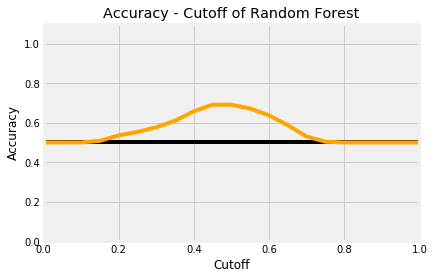

In [23]:
# Acc Curve by cutoff
# ===========================================================
fig = plt.figure()
plt.xlabel('Cutoff')
plt.ylabel('Accuracy')
plt.title('Accuracy - Cutoff of Random Forest')
plt.plot(np.arange(0, 1.1, 0.1), [0.5 for i in np.arange(0, 1.1, 0.1)], color='black')
plt.plot(ROC.column('CUTOFF'), ROC.column('ACC'), color='orange')
plt.axis([0, 1, 0, 1.1])
plt.show()
fig.savefig('Random Forest ACC.png', bbox_inches='tight')

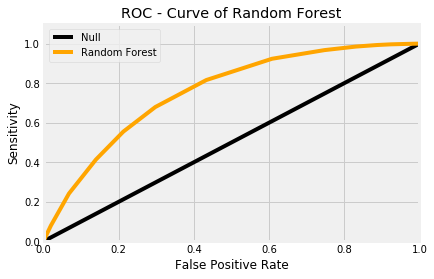

In [27]:
# ROC_CURVE
# ===========================================================
fig = plt.figure()
plt.xlabel('False Positive Rate')
plt.ylabel('Sensitivity')
plt.title('ROC - Curve of Random Forest')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), color='black')
plt.plot(ROC.column('FPR'), ROC.column('SENSITIVITY'), color='orange')
plt.legend(['Null', 'Random Forest'])
plt.axis([0, 1, 0, 1.1])
plt.show()
fig.savefig('Random Forest ROC.png', bbox_inches='tight')

In [25]:
# Compute AUC
# ===========================================================
length = len(ROC.column('FPR'))
auc = 0
for i in range(length - 1):
    auc += 0.5 * abs(ROC.column('FPR')[i + 1] - ROC.column('FPR')[i]) * (ROC.column('SENSITIVITY')[i] + ROC.column('SENSITIVITY')[i + 1])
print("auc = %.03f" %auc)

auc = 0.755


## Method 4: Adaboost

### 1. Initialization

In [50]:
# Initialize useful data
# ===========================================================
df = pd.read_csv('clinvar_conflicting_clean.csv', low_memory=False)
df = df.fillna(value=0)
df_zero = df.loc[df['CLASS'] == 0]
df_zero = df_zero.sample(n=10000)
df_one = df.loc[df['CLASS'] == 1]
df_one = df_one.sample(n=10000)
df = pd.concat([df_zero, df_one])


df = df.sample(n = df.shape[0])
all_rows = df.values.tolist()
row_num = len(all_rows)
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDN,CLNHGVS,...,Codons,STRAND,BAM_EDIT,SIFT,PolyPhen,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62,CLASS
24389,7,107329565,G,A,0.0015,0.00049,0.0022,"MedGen:C0271829,OMIM:274600,Orphanet:ORPHA705,...",Pendred's_syndrome|not_specified|Nonsyndromic_...,NC_000007.13:g.107329565G>A,...,Gct/Act,1.0,0,deleterious,possibly_damaging,0.0893,31.000,6.530930,0.0,1
20778,6,24495330,G,C,0.0000,0.15214,0.0495,"MedGen:C0268631,OMIM:271980,Orphanet:ORPHA22,S...",Succinate-semialdehyde_dehydrogenase_deficienc...,NC_000006.11:g.24495330G>C,...,Ggg/Cgg,1.0,0,tolerated_low_confidence,benign,0.3310,7.725,0.539387,-2.0,0
10322,2,179515472,G,A,0.0067,0.01027,0.0016,"MedGen:C1837342,OMIM:608807,Orphanet:ORPHA1409...","Limb-girdle_muscular_dystrophy,_type_2J|Dilate...",NC_000002.11:g.179515472G>A,...,0,-1.0,0,0,0,0.9710,5.885,0.319935,0.0,0
24402,7,107336428,C,T,0.0086,0.00213,0.0076,"MedGen:C0271829,OMIM:274600,Orphanet:ORPHA705,...",Pendred's_syndrome|not_specified,NC_000007.13:g.107336428C>T,...,ctC/ctT,1.0,0,0,0,0.0893,14.780,1.764608,0.0,0
42057,13,32968808,CT,C,0.0000,0.00000,0.0000,"MedGen:C0027672,SNOMED_CT:699346009|MedGen:C06...",Hereditary_cancer-predisposing_syndrome|Heredi...,NC_000013.10:g.32968816delT,...,0,1.0,OK,0,0,0.0896,3.057,0.047473,0.0,1


### 2. Decision Stump Structure for Adaboost Implementation

In [51]:
# Decision stump part for Adaboost
# ===========================================================
def is_numeric(value):
    return isinstance(value, int) or isinstance(value, float)

# === LeafNode is the prediction result of this branch ===
class LeafNode:
    def __init__(self, rows):
        labels = [row[-1] for row in rows]
#         labels = []
#         self.one_idx = []
#         self.zero_idx = []
#         for i in range(len(rows)):
#             row = rows[i]
#             labels.append(row[-1])
#             if row[-1] == 1:
#                 self.one_idx.append(i)
#             else:
#                 self.zero_idx.append(i)
        self.prediction = collections.Counter(labels)
        
# === DecisionNode is an attribute / question used to partition the data ===
class DecisionNode:
    def __init__(self, question = None, left_branch = None, right_branch = None):
        self.question = question
        self.left_branch = left_branch
        self.right_branch = right_branch
    
class DecisionStump:
    def __init__(self, training_attribute, training_data, height, method = "CART"):
        self.attribute = training_attribute     # takein attribute and data separately
        self.train = training_data
        self.height = height
        self.row_num = len(self.train)
        self.column_num = len(self.attribute)
        self.method = method.upper()            # convert to upper case for general use
        self.significance = 0
        if self.method not in ["C4.5", "CART", "HYBRID"]:
            print("Error: Please choose a valid method! from: [C4.5, CART, HYBRID]")
            return None
        
        # train decision stump
        self.root = self.build_stump(self.train, 1)
        
        # count ACC classifications and mis classifications to update weights
        self.accclassify_idx = []
        self.misclassify_idx = []
        # Only after DecisionStump trained, can we know which rows are misclassified 
        # Walk down the decision stump to collect all misclassification indices
        
#         if self.root.left_branch.prediction.get(1, 0) > self.root.left_branch.prediction.get(0, 0):
#             # then consider the prediction of this leaf node as 1: 1 -> correct, 0 -> misclassify
#             self.accclassify_idx += self.root.left_branch.one_idx
#             self.misclassify_idx += self.root.left_branch.zero_idx
#         else:
#             # then consider the prediction of this leaf node as 0: 0 -> correct, 1 -> misclassify
#             self.accclassify_idx += self.root.left_branch.zero_idx
#             self.misclassify_idx += self.root.left_branch.one_idx
#         if self.root.right_branch.prediction.get(1, 0) > self.root.right_branch.prediction.get(0, 0):
#             # then consider the prediction of this leaf node as 1: 1 -> correct, 0 -> misclassify
#             self.accclassify_idx += self.root.right_branch.one_idx
#             self.misclassify_idx += self.root.right_branch.zero_idx
#         else:
#             # then consider the prediction of this leaf node as 0: 0 -> correct, 1 -> misclassify
#             self.accclassify_idx += self.root.right_branch.zero_idx
#             self.misclassify_idx += self.root.right_branch.one_idx
    
    def uniq_val(self, column):
        return set([self.train[i][column] for i in range(len(self.train))])
    
    # when raising a question.
    # if it's a categorical attribute, we simply iterate all categories
    # if it's a numeric attribute, we iterate the set of possible numeric values 
    class Question:
        def __init__(self, column, ref_value, attribute):
            self.column = column
            self.ref_value = ref_value if ref_value else "None"
            self.attri = attribute

        def match(self, row):
            if is_numeric(self.ref_value):
                try:
                    return row[self.column] >= self.ref_value
                except:
                    print("Error occured in ", row)
                    return True
            else:
                return row[self.column] == self.ref_value

        def __repr__(self):
            operand = ">=" if is_numeric(self.ref_value) else "=="
            return "Is %s %s %s?" % (self.attri[self.column], operand, str(self.ref_value))
    
    # === Method 1 - C4.5 ===
    def entropy(self, rows):
        # === Bits used to store the information ===
        labels = [row[-1] for row in rows]
        frequency = collections.Counter(labels).values()
        pop = sum(frequency)
        H = 0
        for f in frequency:
            p = f / pop
            H -= p * math.log(p, 2)
        return H
    
    # === Method 2 - CART ===
    def gini(self, rows):
        # === Probability of misclassifying any of your label, which is impurity ===
        labels = [row[-1] for row in rows]
        frequency = collections.Counter(labels).values()
        pop = sum(frequency)
        gini = 1
        for f in frequency:
            p = f / pop
            gini -= p ** 2
        return gini
    
    # === Calculate Gain Info ===
    def info(self, branches, root):
        # === Objective: to find the best question which can maximize info ===
        root_size = float(len(root))
        if self.method == "C4.5":  # Here I pick the GainRatio Approach
            root_uncertainty = self.entropy(root)
            gain_info = root_uncertainty
            split_info = 0
            for branch in branches:
                if not branch: continue
                gain_info -= len(branch) / root_size * self.entropy(branch)
                split_info -= float(len(branch)) / root_size * math.log(float(len(branch)) / root_size)
#                 print(gain_info, split_info)
            return gain_info / split_info
        elif self.method == "CART":
            root_uncertainty = self.gini(root)
            gain_info = root_uncertainty
            for branch in branches:
                if not branch: continue
                gain_info -= len(branch) / root_size * self.gini(branch)
            return gain_info
        elif self.method == "HYBRID":
            pass
        pass
    
    # === Here I only do Binary Partitions ===
    def partition(self, rows, question):
        true_rows = []
        false_rows = []
        for row in rows:
            if question.match(row):
                true_rows.append(row)
            else:
                false_rows.append(row)
        return true_rows, false_rows
    
    # the question that achieves the max infomation attenuation is the best question
    def find_best_question(self, rows):
        max_info_attenuation = 0
        best_question = self.Question(0, self.train[0][0], self.attribute)
        # === Iterate through all question candidates ===
        # === TODO: Maybe Iteration here can be optimized ===
        for col in range(self.column_num - 1): # minus 1 to avoid using the label as attribute
            ref_candidates = self.uniq_val(col)
            for ref_value in ref_candidates:
                if ref_value == "null": continue # avoid using null values to generate a question
                q = self.Question(col, ref_value, self.attribute)
                temp_true_rows, temp_false_rows = self.partition(rows, q)
                temp_info_attenuation = self.info([temp_true_rows, temp_false_rows], rows)
                if temp_info_attenuation >= max_info_attenuation:
                    max_info_attenuation = temp_info_attenuation
                    best_question = q
        return max_info_attenuation, best_question
        
    # === Input rows of data with attributes and labels ===
    def build_stump(self, rows, height):
        # === Assign all rows as root of the whole decision tree ===
        # === We have met the leaf node if gini(rows) is 0 or no question candidates left ===
        gain_reduction, q = self.find_best_question(rows)
        true_rows, false_rows = self.partition(rows, q)
        if height + 1 >= self.height:
            return DecisionNode(q, LeafNode(true_rows), LeafNode(false_rows))
        else:
            return DecisionNode(q, self.build_stump(true_rows, height + 1), self.build_stump(false_rows, height + 1))
    
    # === Input a row of data with attributes (and no label), predict its label with our decision tree ===
    # === Actually it can contain a label, we just don't use it ===
    # === walk down the decision tree until we reach the leaf node ===
    def classify(self, row, node):
        if isinstance(node, LeafNode):
            # do a mapping from label[1, 0] to label[1, -1]
            return node.prediction
#             return 1 if node.prediction.get(1, 0) / (node.prediction.get(1, 0) + node.prediction.get(0, 0)) > cutoff else -1
        
        if node.question.match(row):
            return self.classify(row, node.left_branch)
        else:
            return self.classify(row, node.right_branch)

    # function to print the tree out
    def print_tree(self, node, spacing=""):
        # Base case: we've reached a leaf
        if isinstance(node, LeafNode):
            print (spacing + "Predict", node.prediction)
            return

        # Print the question at this node
        print (spacing + str(node.question))

        # Call this function recursively on the true branch
        print (spacing + '--> True:')
        self.print_tree(node.left_branch, spacing + "  ")

        # Call this function recursively on the false branch
        print (spacing + '--> False:')
        self.print_tree(node.right_branch, spacing + "  ")
    
    def test(self):
        for i in range(self.column_num):
            q = self.Question(i, self.train[1][i], self.attribute)
            print(q)
            print(q.match(1))
            
def normalized_weight(weight):
    return np.divide(weight, sum(weight))

def rev_logit(val):
    return 1 / (1 + np.exp(val))

### 3. Merged Adaboost Algorithm
#### Note: Don't try to run this cell, it takes too long to finish.
#### b.c. I have to feed in sufficient amount of data to prevent it from overfitting
#### I ran this cell for different cutoffs separately with Kaggle online kernel
#### So the Acc and ROC curves don't look smooth.

In [ ]:
'''
# Merged Adaboost
# ===========================================================
# Init, Train, Test together
# ===========================================================
training_percentage = 0.2  # percent of partition of training dataset
training_size = int(row_num * training_percentage)
testing_size = row_num - training_size
training_attribute = list(df.columns)
testing_data = all_rows[training_size: ]   # testing data don't need to include header row

T = 20
weaklearner_height = 4

ROC = Table(make_array('CUTOFF', 'TN', 'FN', 'FP', 'TP', 'ACC'))
step_size = 0.05

CMap = {0: 'TN', 1: 'FN', 2: 'FP', 3: 'TP'}

start = time.time()

for cutoff in np.arange(0, 1 + step_size, step_size):
    # interactive printing
    sys.stdout.write('\r')
    sys.stdout.write("Boosting: [%-20s] %d%%  cutoff: %.02f" % ('='*int(cutoff * 100 / 5), int(cutoff * 100), cutoff))
    sys.stdout.flush()
    
    # Reinit training set
    # ===========================================================
    training_data = all_rows[: training_size]  
    
    # Training for this cutoff
    # ===========================================================
    stump_forest = []
    weight = [1 / training_size for _ in range(training_size)]
    
    for i in range(T):
        # train a decision stump
        stump = DecisionStump(training_attribute, training_data, weaklearner_height, "CART")

        # calculate the total error of the stump after it's trained
        for j in range(training_size):
            row = training_data[j]
            pred_counter = stump.classify(row, stump.root)
            pred_label = 1 if pred_counter.get(1, 0) / (pred_counter.get(1, 0) + pred_counter.get(0, 0) + 0.00000001) > cutoff else 0
            if pred_label == row[-1]:
                stump.accclassify_idx.append(j)
            else:
                stump.misclassify_idx.append(j)
        accuracy = len(stump.accclassify_idx) / training_size
        total_err_rate = 1 - accuracy

        # update the significance level of this stump, remember not to divide by zero
        stump.significance = 0.5 * math.log((1 - total_err_rate + 0.0001) / (total_err_rate + 0.0001))

        # append stump into the forest
        stump_forest.append(stump)
        # if len(stump_forest) == T: break  # early break

        # update training_data weight, resample the training data with the updated weight distribution
        true_scale = np.e ** stump.significance
        for idx in stump.misclassify_idx:
            weight[idx] = weight[idx] * true_scale
        for idx in stump.accclassify_idx:
            weight[idx] = weight[idx] * (1 / true_scale)
        distrib = normalized_weight(weight)

        resampled_idx = np.random.choice(training_size, training_size, p = distrib)
        training_data = [training_data[idx] for idx in resampled_idx]
        if len(set([row[1] for row in training_data])) < 0.04 * training_size: break
        
#         print(i, len(set([row[1] for row in training_data])), stump.significance, end='\n')
        
        # re-init the weight of the training data rows to be even
        weight = [1 / training_size for _ in range(training_size)]

#     forest_size = len(stump_forest)

    # Testing for this cutoff
    # ===========================================================
    Confusion = {'TN': 0, 'FN': 0, 'FP': 0, 'TP': 0}
    for row in testing_data:
        true_rate_forest = 0
        for tree_i in stump_forest:
            
            # prediction is a counter of label 1 and 0
            pred_counter = tree_i.classify(row, tree_i.root)
            
            # do a mapping from label[1, 0] to label[1, -1]
            true_rate_tree = 1 if pred_counter.get(1, 0) / (pred_counter.get(1, 0) + pred_counter.get(0, 0) + 0.00000001) > cutoff else -1
            true_rate_forest += true_rate_tree * tree_i.significance
#         true_rate_forest = rev_logit(true_rate_forest)
#         true_pred = 1 if true_rate_forest >= cutoff else 0
        true_pred = 0 if np.sign(true_rate_forest) <= 0 else 1
        indicator = (true_pred << 1) + row[-1]
        
        # accordingly update confusion matrix
        Confusion[CMap[indicator]] += 1
        
    # concatenate the confusion matrix values into the overall ROC Table
    thisline = [cutoff] + list(Confusion.values()) + [(Confusion['TP'] + Confusion['TN']) / sum(Confusion.values())]
    ROC = ROC.with_row(thisline)
    
end = time.time()
print("\nTime: %.02fs" % (end - start))
ROC = ROC.with_columns('SENSITIVITY', ROC.apply(lambda TP, FN: TP / (TP + FN + 0.00000001), 'TP', 'FN'))
ROC = ROC.with_columns('FPR', ROC.apply(lambda TN, FP: FP / (TN + FP + 0.00000001), 'TN', 'FP'))
ROC = ROC.with_column('FMEAS', ROC.apply(lambda TP, FP, FN: 2 * (TP / (TP + FN)) * (TP / (TP + FP)) / (TP / (TP + FN) + TP / (TP + FP)), 'TP', 'FP', 'FN'))
'''

### I hardcoded the performance wrt cutoffs according to the result printed on Kaggle Kernel

In [52]:
AD_CUTOFF = np.arange(0, 1 + 0.05, 0.05)
AD_ACC = np.array([0.50075, 0.571063, 0.585625, 0.57625, 0.616688, 0.652,
                   0.652875, 0.661563, 0.641375, 0.651813, 0.623125, 0.606563,
                   0.575937, 0.62875, 0.623625, 0.644437, 0.603125, 0.591187,
                   0.499125, 0.493125, 0.500625])

AD_FPR = np.array([0.0017452006980781037, 0.01959071624654406, 0.021771037181969457,
                   0.12116296481142855, 0.16745695033670147, 0.21425006239054872,
                   0.2968555028696071, 0.34560378062387065, 0.3486398802091981,
                   0.3742201147986346, 0.3843181251553424, 0.41290242076314837,
                   0.41677065135959973, 0.4293735962061026, 0.5103842805614844,
                   0.5154729223851816, 0.6032831737338599, 0.7298843427425322,
                   0.7780126849884617, 0.800522323093147, 0.9999999999987522])

AD_TPR = np.array([0.0005013787916764836, 0.0015337423312863834, 0.004132231404953503,
                   0.30252942649598985, 0.37290257951368283, 0.4482844978707134,
                   0.5026296018025261, 0.5616078136732261, 0.6306091752310973,
                   0.6317305284239523, 0.6513381078016693, 0.6997245179054599,
                   0.7332832456790217, 0.7362885048826242, 0.7632106185815637,
                   0.8160572936288277, 0.8389244879999511, 0.9043849729854198,
                   0.9237341374532935, 0.956904133683934, 0.9999999999987478])

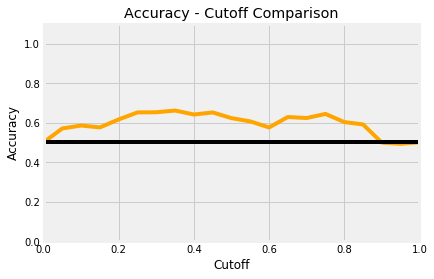

In [53]:
# Acc Curve by cutoff
# ===========================================================
fig = plt.figure()
plt.xlabel('Cutoff')
plt.ylabel('Accuracy')
plt.title('Accuracy - Cutoff Comparison')

plt.plot(AD_CUTOFF, AD_ACC, color='orange')
plt.plot(np.arange(0, 1.1, 0.1), [0.5 for i in np.arange(0, 1.1, 0.1)], color='black')
plt.axis([0, 1, 0, 1.1])
plt.show()
fig.savefig('Adaboost ACC.png', bbox_inches='tight')

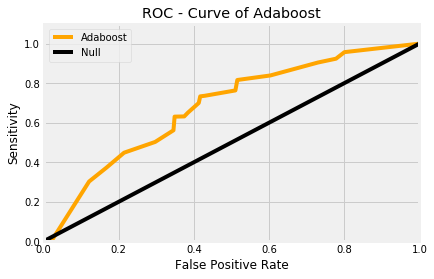

In [54]:
# ROC_CURVE
# ===========================================================
fig = plt.figure()
plt.xlabel('False Positive Rate')
plt.ylabel('Sensitivity')
plt.title('ROC - Curve of Adaboost')
plt.plot(AD_FPR, AD_TPR, color='orange')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), color='black')
plt.legend(['Adaboost', 'Null'])
plt.axis([0, 1, 0, 1.1])
plt.show()
fig.savefig('Adaboost ROC.png', bbox_inches='tight')

In [55]:
# Compute AUC
# ===========================================================
length = len(AD_FPR)
auc = 0
for i in range(length - 1):
    auc += 0.5 * abs(AD_FPR[i + 1] - AD_FPR[i]) * (AD_TPR[i] + AD_TPR[i + 1])
print("auc = %.03f" %auc)

auc = 0.679


## Conclusion

Among all 4 methods: Random Forest hits the highest accuracy.


Note: the result shown in the comparison may be slightly different from what we got above, b.c. I had re-run the algorithms after merging them into this file, but i didn't update the data used to plot the comparison below for convenience.

In [56]:
# Logistic Regression
LR_CUTOFF = np.arange(0, 1 + 0.05, 0.05)
LR_ACC = np.array([0.5  , 0.546, 0.568, 0.59 , 0.594, 0.6  , 0.594, 0.578, 0.578,
       0.596, 0.61 , 0.598, 0.584, 0.572, 0.564, 0.55 , 0.552, 0.554,
       0.546, 0.54 , 0.5  ])
LR_FPR = np.array([1.   , 0.84 , 0.76 , 0.672, 0.628, 0.588, 0.556, 0.548, 0.516,
       0.456, 0.404, 0.372, 0.34 , 0.324, 0.3  , 0.276, 0.232, 0.184,
       0.104, 0.048, 0.   ])
LR_TPR = np.array([1.   , 0.932, 0.896, 0.852, 0.816, 0.788, 0.744, 0.704, 0.672,
       0.648, 0.624, 0.568, 0.508, 0.468, 0.428, 0.376, 0.336, 0.292,
       0.196, 0.128, 0.   ])

# Decision Tree
DT_CUTOFF = np.arange(0, 1 + 0.05, 0.05)
DT_ACC = np.array([0.49974747, 0.56691919, 0.58813131, 0.60368687, 0.60368687,
       0.60368687, 0.60368687, 0.60368687, 0.62378788, 0.62378788,
       0.62378788, 0.62378788, 0.62378788, 0.6309596 , 0.6309596 ,
       0.5030303 , 0.5030303 , 0.5030303 , 0.49959596, 0.49959596,
       0.50025253])

DT_FPR = np.array([1.        , 0.83281171, 0.73255931, 0.69156991, 0.69156991,
       0.69156991, 0.69156991, 0.69156991, 0.4503786 , 0.4503786 ,
       0.4503786 , 0.4503786 , 0.4503786 , 0.24967188, 0.24967188,
       0.03705199, 0.03705199, 0.03705199, 0.01373044, 0.01373044,
       0.        ])
DT_TPR = np.array([1.        , 0.96705407, 0.90914603, 0.89924204, 0.89924204,
       0.89924204, 0.89924204, 0.89924204, 0.69802931, 0.69802931,
       0.69802931, 0.69802931, 0.69802931, 0.51147044, 0.51147044,
       0.0426478 , 0.0426478 , 0.0426478 , 0.01243052, 0.01243052,
       0.        ])

# Random Forest
RF_CUTOFF = np.arange(0, 1 + 0.05, 0.05)
RF_ACC = np.array([0.50020202, 0.50020202, 0.50040404, 0.50787879, 0.53449495,
       0.56217172, 0.58393939, 0.61020202, 0.64343434, 0.67575758,
       0.68464646, 0.67070707, 0.6379798 , 0.58712121, 0.5370202 ,
       0.50757576, 0.50005051, 0.49974747, 0.49979798, 0.49979798,
       0.49979798])

RF_FPR = np.array([1.00000000e+00, 1.00000000e+00, 9.99595796e-01, 9.84033953e-01,
       9.28556993e-01, 8.67825384e-01, 8.14167340e-01, 7.39894907e-01,
       6.29951496e-01, 4.84033953e-01, 3.53678254e-01, 2.43835893e-01,
       1.54203719e-01, 7.97291835e-02, 2.84963622e-02, 6.16410671e-03,
       8.08407437e-04, 1.01050930e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

RF_TPR = np.array([1.        , 1.        , 1.        , 0.99939418, 0.99717286,
       0.99182149, 0.98172456, 0.96001616, 0.91659935, 0.83542003,
       0.72294023, 0.58531906, 0.43033118, 0.25424071, 0.10288772,
       0.0217084 , 0.0013126 , 0.        , 0.        , 0.        ,
       0.        ])

# Adaboost
AD_CUTOFF = np.arange(0, 1 + 0.05, 0.05)
AD_ACC = np.array([0.50075 , 0.571063, 0.585625, 0.57625 , 0.616688, 0.652   ,
       0.652875, 0.661563, 0.641375, 0.651813, 0.623125, 0.606563,
       0.575937, 0.62875 , 0.623625, 0.644437, 0.603125, 0.591187,
       0.499125, 0.493125, 0.500625])

AD_FPR = np.array([0.0017452006980781037, 0.01959071624654406, 0.021771037181969457,
                   0.12116296481142855, 0.16745695033670147, 0.21425006239054872,
                   0.2968555028696071, 0.34560378062387065, 0.3486398802091981,
                   0.3742201147986346, 0.3843181251553424, 0.41290242076314837,
                   0.41677065135959973, 0.4293735962061026, 0.5103842805614844,
                   0.5154729223851816, 0.6032831737338599, 0.7298843427425322,
                   0.7780126849884617, 0.800522323093147, 0.9999999999987522])

AD_TPR = np.array([0.0005013787916764836, 0.0015337423312863834, 0.004132231404953503,
                   0.30252942649598985, 0.37290257951368283, 0.4482844978707134,
                   0.5026296018025261, 0.5616078136732261, 0.6306091752310973,
                   0.6317305284239523, 0.6513381078016693, 0.6997245179054599,
                   0.7332832456790217, 0.7362885048826242, 0.7632106185815637,
                   0.8160572936288277, 0.8389244879999511, 0.9043849729854198,
                   0.9237341374532935, 0.956904133683934, 0.9999999999987478])

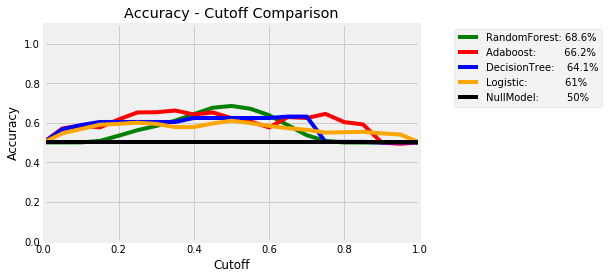

In [57]:
# Acc Curve by cutoff
# ===========================================================
fig = plt.figure()
plt.xlabel('Cutoff')
plt.ylabel('Accuracy')
plt.title('Accuracy - Cutoff Comparison')
plt.plot(RF_CUTOFF, RF_ACC, color='green')
plt.plot(AD_CUTOFF, AD_ACC, color='red')
plt.plot(DT_CUTOFF, DT_ACC, color='blue')
plt.plot(LR_CUTOFF, LR_ACC, color='orange')
plt.plot(np.arange(0, 1.1, 0.1), [0.5 for i in np.arange(0, 1.1, 0.1)], color='black')
plt.axis([0, 1, 0, 1.1])
plt.legend(['RandomForest: 68.6%', 'Adaboost:         66.2%', 'DecisionTree:    64.1%', 'Logistic:            61%', 'NullModel:         50%'], loc='best', bbox_to_anchor=(0.5, 0.5, 1, 0.5))
plt.show()
fig.savefig('Accuracy - Cutoff Comparison.png', bbox_inches='tight')

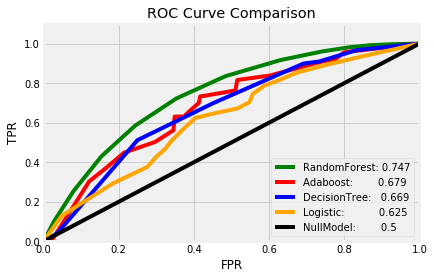

In [58]:
# ROC Curve
# ===========================================================
fig = plt.figure()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve Comparison')
plt.plot(RF_FPR, RF_TPR, color='green')
plt.plot(AD_FPR, AD_TPR, color='red')
plt.plot(DT_FPR, DT_TPR, color='blue')
plt.plot(LR_FPR, LR_TPR, color='orange')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), color='black')
plt.axis([0, 1, 0, 1.1])
plt.legend(['RandomForest: 0.747', 'Adaboost:        0.679', 'DecisionTree:   0.669', 'Logistic:           0.625', 'NullModel:        0.5'])
plt.show()
fig.savefig('ROC Curve Comparison.png', bbox_inches='tight')